# Temperature Estimate and "Round-Tripping"
## February 28, 2022

Hello! This is a tutorial that will guide you through how I get temperature information from a methyl cyanide "ladder" in our data on The Brick.

## Table of Contents

1. Retreive data on spectral lines
2. Generate noise map
3. Generate N_upper from mom0, propagate errors
4. Prepare for fitting temperature and N_tot, filtration step
5. Loop over each pixel to make maps of temperature and N_tot
6. Make diagnostic plots for every pixel
7. Walking through the math for an individual pixel
8. Synthetic and real spectra comparison

In [1]:
# Front matter
%matplotlib inline
import pylab as pl
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 150 # For making plots easier to read
plt.rcParams['figure.facecolor'] = 'w' # For making plot axis labels visible even on dark backgrounds
import warnings
warnings.filterwarnings('ignore')

In [2]:
from dask.diagnostics import ProgressBar
ProgressBar().register() # For showing time elapsed on cells

## Step 1: Retrieve data on lines

First, we'll retrieve some values we need for each rung from the methyl cyanide cube table.

In [3]:
from spectral_cube import SpectralCube
from astropy import units as u
from lte_modeling_tools import get_molecular_parameters
from astropy import constants

# User inputs
results = '/blue/adamginsburg/abulatek/brick/symlinks/imaging_results/'
freq_spw = '146_spw51'
fmin = 147.035*u.GHz # ch3cncube.spectral_axis.min() # I should not have to hard-code these... but I don't want other lines creeping in
fmax = 147.175*u.GHz # ch3cncube.spectral_axis.max()

In [4]:
def retrieve_cube(results, freq_spw):
    '''Get methyl cyanide (target molecule) cube'''
    fn = results+'source_ab_'+freq_spw+'_clean_2sigma_n50000_masked_3sigma_pbmask0p18.image'
    ch3cncube = SpectralCube.read(fn, format='casa_image')
    ch3cn_freqs, ch3cn_A, ch3cn_g, ch3cn_E_U, ch3cn_partfunc = get_molecular_parameters('CH3CN',
                                                                                        fmin=fmin, 
                                                                                        fmax=fmax, 
                                                                                        catalog='JPL')
    # We're readying the partition function for use with temperature map later!
    ch3cn_A_new = 10**ch3cn_A*u.s**-1 # Original is log_10(A_ij), this line gets us just A_ij and gives it units
    # DO NOT RUN THE FOLLOWING LINE, WHATEVER YOU DO
    # ch3cn_E_U = ch3cn_E_U/constants.k_B # Original is in erg
    return ch3cncube, ch3cn_freqs, ch3cn_A_new, ch3cn_g, ch3cn_E_U, ch3cn_partfunc, ch3cn_A

In [5]:
ch3cncube, ch3cn_freqs, ch3cn_A, ch3cn_g, ch3cn_E_U, ch3cn_partfunc, ch3cn_A_orig = retrieve_cube(results, freq_spw)
ch3cncube

DaskVaryingResolutionSpectralCube with shape=(3840, 512, 512) and unit=Jy / beam and chunk size (128, 128, 512):
 n_x:    512  type_x: RA---SIN  unit_x: deg    range:   266.528130 deg:  266.560501 deg
 n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -28.719152 deg:  -28.690763 deg
 n_s:   3840  type_s: FREQ      unit_s: Hz     range: 145582599820.702 Hz:147457166014.871 Hz

In [6]:
from spectral_cube import OneDSpectrum
from astropy.io import fits
import pyspeckit

spectra = '/blue/adamginsburg/abulatek/brick/symlinks/imaging_results/spectra/'
max_fn = spectra+'source_ab_'+freq_spw+'_clean_2sigma_n50000_masked_3sigma_pbmask0p18.max.fits'
mean_fn = spectra+'source_ab_'+freq_spw+'_clean_2sigma_n50000_masked_3sigma_pbmask0p18.mean.fits'

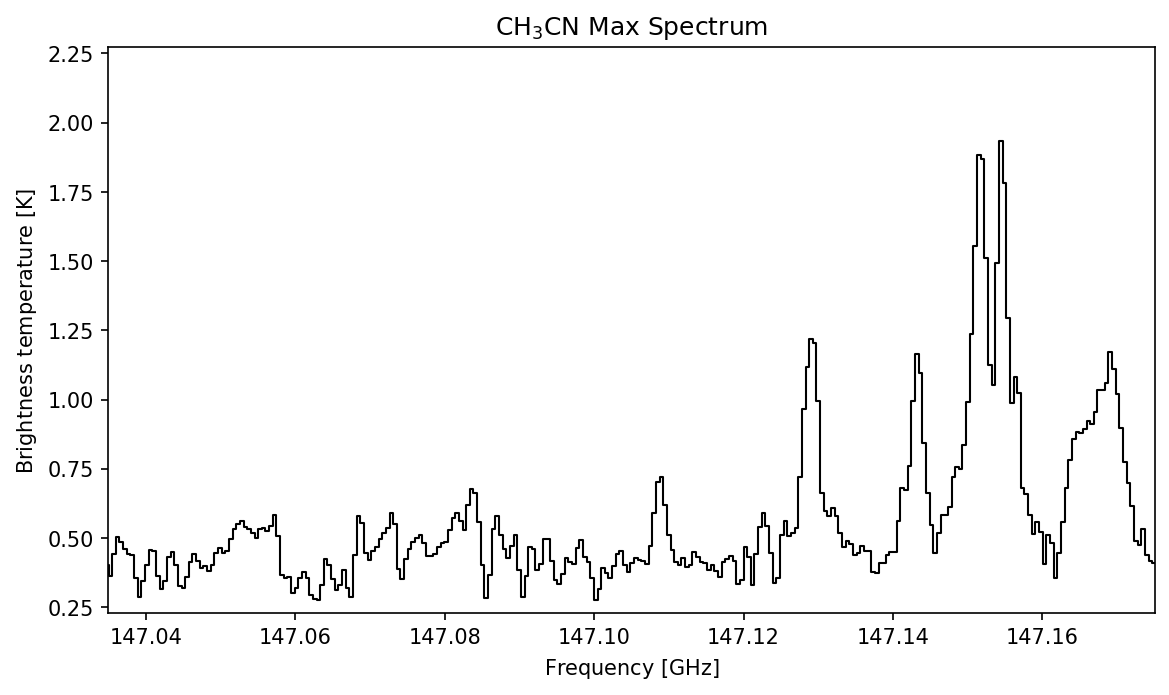

In [7]:
# Plot methyl cyanide max spectrum
fig1 = plt.figure(1, figsize = (9, 5))
max_kspectrum = OneDSpectrum.from_hdu(fits.open(max_fn)).to(u.K)
max_kspectrum_ps = pyspeckit.Spectrum.from_hdu(max_kspectrum.hdu)
max_kspectrum_ps.xarr.convert_to_unit('GHz')
max_kspectrum_ps.plotter(figure = fig1, color = 'k', linewidth = 1, xmin = fmin, xmax = fmax,
                         xlabel = f"Frequency [{max_kspectrum_ps.xarr.unit.to_string('latex_inline')}]", 
                         ylabel = f"Brightness temperature [{max_kspectrum_ps.unit.to_string('latex_inline')}]",
                         title = "CH$_3$CN Max Spectrum")
max_kspectrum_ps.plotter.savefig(f'../figures/ch3cn_max_spec.pdf', facecolor='w', edgecolor='w', bbox_inches='tight')
plt.show()

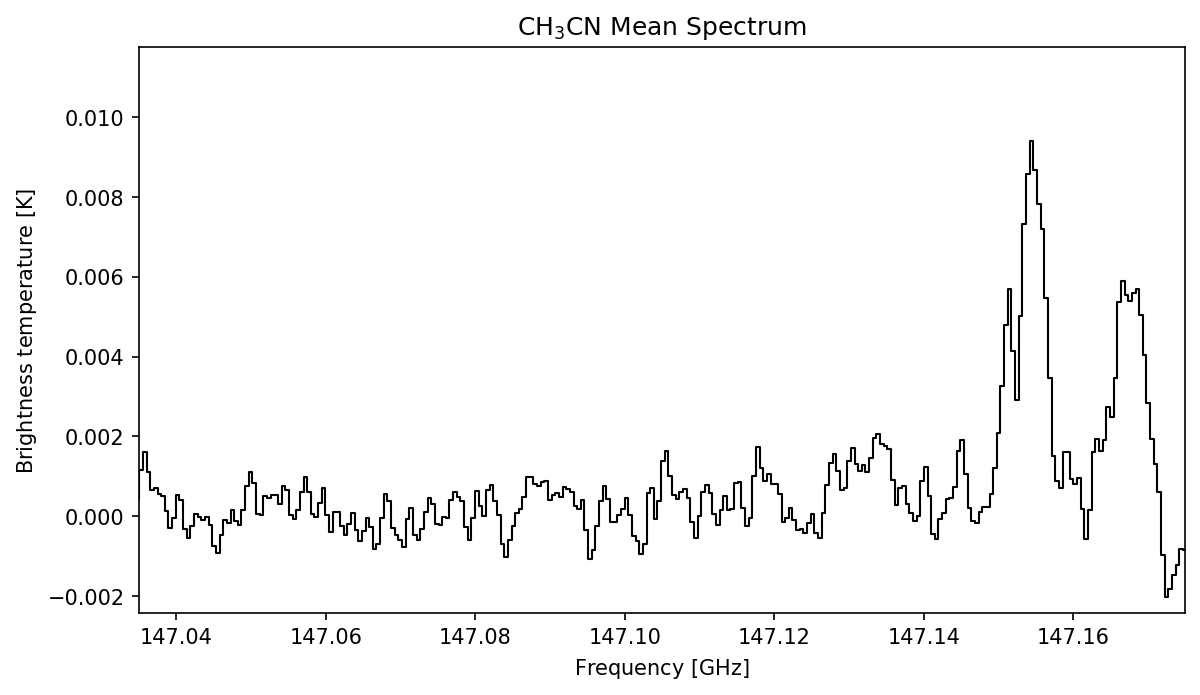

In [8]:
# Plot methyl cyanide mean spectrum
fig2 = plt.figure(2, figsize = (9, 5))
mean_kspectrum = OneDSpectrum.from_hdu(fits.open(mean_fn)).to(u.K)
mean_kspectrum_ps = pyspeckit.Spectrum.from_hdu(mean_kspectrum.hdu)
mean_kspectrum_ps.xarr.convert_to_unit('GHz')
mean_kspectrum_ps.plotter(figure = fig2, color = 'k', linewidth = 1, xmin = fmin, xmax = fmax,
                          xlabel = f"Frequency [{max_kspectrum_ps.xarr.unit.to_string('latex_inline')}]", 
                          ylabel = f"Brightness temperature [{max_kspectrum_ps.unit.to_string('latex_inline')}]",
                          title = "CH$_3$CN Mean Spectrum")
plt.show()

<Figure size 1350x750 with 0 Axes>

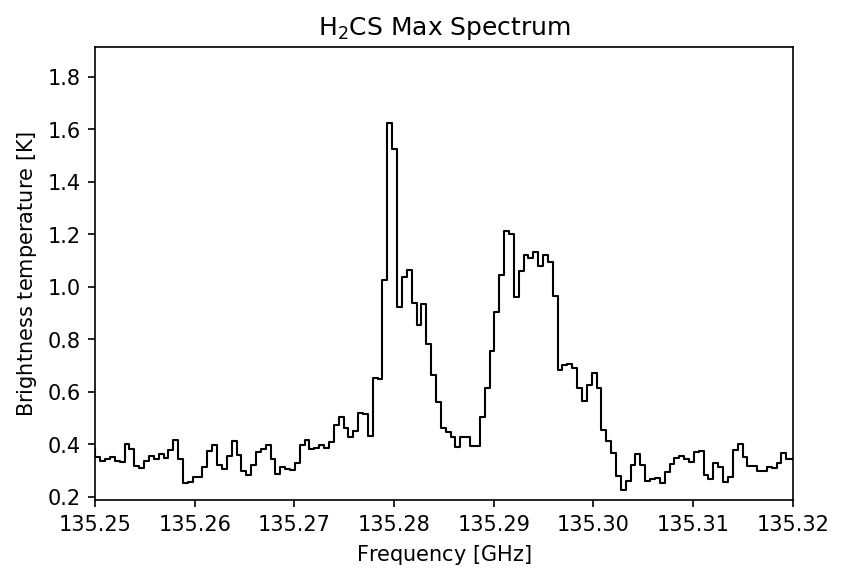

In [9]:
freq_spw_2 = '135_spw47'
fmin = 135.25*u.GHz
fmax = 135.32*u.GHz
max_fn_2 = spectra+'source_ab_'+freq_spw_2+'_clean_2sigma_n50000_masked_3sigma_pbmask0p18.max.fits'
mean_fn_2 = spectra+'source_ab_'+freq_spw_2+'_clean_2sigma_n50000_masked_3sigma_pbmask0p18.mean.fits'
# Plot formaldehyde max spectrum
fig3 = plt.figure(3, figsize = (9, 5))
max_kspectrum = OneDSpectrum.from_hdu(fits.open(max_fn_2)).to(u.K)
max_kspectrum_ps = pyspeckit.Spectrum.from_hdu(max_kspectrum.hdu)
max_kspectrum_ps.xarr.convert_to_unit('GHz')
max_kspectrum_ps.plotter(figure = fig1, color = 'k', linewidth = 1, xmin = fmin, xmax = fmax,
                         xlabel = f"Frequency [{max_kspectrum_ps.xarr.unit.to_string('latex_inline')}]", 
                         ylabel = f"Brightness temperature [{max_kspectrum_ps.unit.to_string('latex_inline')}]",
                         title = "H$_2$CS Max Spectrum")
max_kspectrum_ps.plotter.savefig(f'../figures/h2cs_max_spec.pdf', facecolor='w', edgecolor='w', bbox_inches='tight')
plt.show()

## Step 2: Generate noise map

Now, we'll import the noise map (generated in our masking process), from which we'll begin error propagation. In general, the noise map should have little to no coherent structure. It should be uniformly bright with only noise-like variations across the map.

In [10]:
from pylab import imshow
from astropy.io import fits
from astropy.visualization import quantity_support

In [11]:
def generate_noise_map():
    '''Generate noise map from filename (hard-coded)'''
    hdu = fits.open('methyl_cyanide/template_noise.fits')
    noise_map = hdu[0].data*u.K # Generally, should NOT enforce units like this, but smarter solution is not implemented yet
    imshow(noise_map.value, origin='lower')
    return noise_map

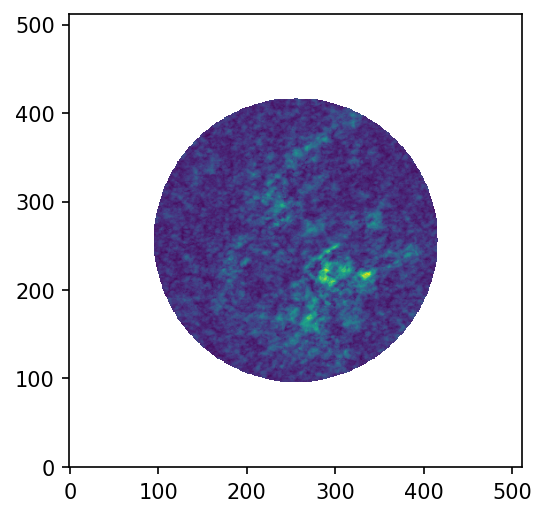

In [12]:
noise_map = generate_noise_map()

## Step 3: Generate N_upper from mom0, propagate errors

Now, we'll go through each rung of the ladder and get the upper state column density from the moment 0 map for each rung. We'll store those upper state column density maps for fitting in the next step, and we'll plot the moment 0 maps next to the upper state column density maps for each *k*-component.

We will also propagate errors on the noise map for each of the *k*-components.

In [13]:
import numpy as np
from lte_modeling_tools import nupper_of_kkms
from astropy import constants

In [14]:
def generate_N_upper(ch3cn_freqs, ch3cn_A, ch3cn_g):
    '''Get upper state column density maps from filenames (hard-coded)'''
    log_N_upper_gs = []
    log_N_upper_g_errs = []
    
    kmax = len(ch3cn_freqs) - 1 # Maximum rotational quantum number for the ladder

    for i in range(len(ch3cn_freqs)): # i is the index of the loop
        
        kk = kmax - i # Get rotational quantum number of this iteration

        if kk == 0 or kk == 1:
            # Import k = 0 and k = 1 cubes
            if kk == 0:
                # We need something to be called masked_cube to get channel_width and number_of_pixels
                masked_cube = SpectralCube.read(f'methyl_cyanide/ch3cn_0_masked.fits', format='fits')
            elif kk == 1:
                # We need something to be called masked_cube to get channel_width and number_of_pixels
                masked_cube = SpectralCube.read(f'methyl_cyanide/ch3cn_1_masked.fits', format='fits')
            masked_cube_0 = SpectralCube.read(f'methyl_cyanide/ch3cn_0_masked.fits', format='fits')
            print("k = 0:", masked_cube_0.with_spectral_unit(u.GHz, rest_value = ch3cn_freqs[kmax - 0]))
            masked_cube_1 = SpectralCube.read(f'methyl_cyanide/ch3cn_1_masked.fits', format='fits')
            print("k = 1:", masked_cube_1.with_spectral_unit(u.GHz, rest_value = ch3cn_freqs[kmax - 1]))
            # Get frequency range we want: highest freq in k = 1, highest freq in k = 0
            highest_freq_1 = np.max(masked_cube_1.with_spectral_unit(u.GHz, rest_value = ch3cn_freqs[kmax - 1]).spectral_axis)
            highest_freq_0 = np.max(masked_cube_0.with_spectral_unit(u.GHz, rest_value = ch3cn_freqs[kmax - 0]).spectral_axis)
            # Get extra part of k = 0 that's not in k = 1 cube
            extra_part_of_0 = masked_cube_0.with_spectral_unit(u.GHz, rest_value = ch3cn_freqs[kmax - 0]).spectral_slab(highest_freq_1, 
                                                                                                                        highest_freq_0)
            print("section of k = 0 that's not in k = 1:", extra_part_of_0)
            extra_part_of_0 = extra_part_of_0.with_spectral_unit(u.km/u.s, velocity_convention = 'radio')
            mom0_sum = extra_part_of_0.moment0() + masked_cube_1.moment0()
            # Split equally between k = 0 and k = 1 component
            mom0 = mom0_sum/2
        else: 
            # Import masked cube and get channel width
            masked_cube = SpectralCube.read(f'methyl_cyanide/ch3cn_{kk}_masked.fits', format='fits')
            # primary_beam = SpectralCube.read(results+'source_ab_'+freq_spw+'_clean_2sigma_n50000_masked_3sigma_pbmask0p18.pb',
            #                                  format='casa_image')
            # masked_cube = masked_cube/primary_beam # Correct for effect of primary beam

            # Calculate moment 0 and moment 1 maps of cube
            mom0 = masked_cube.moment0()
            # mom1 = masked_cube.moment1()
    
        channel_width = np.diff(masked_cube.spectral_axis)[0]

        # Propagate error on integrated intensity
        number_of_pixels = masked_cube.mask.include().sum(axis=0)
        noise_map_int = noise_map*channel_width*np.sqrt(number_of_pixels) # Noise map WAS in Jy/beam... now K
            # Why were we not multiplying by the channel width???

        # Calculate what the shifted line frequency for the rung should be (per pixel) with mom1
        #shifted_line_freqs = (ch3cn_freqs[i]-((mom1/(constants.c.to(u.km/u.s)))*ch3cn_freqs[i])).to(u.GHz) # Maybe okay?

        # Calculate upper state column density from integrated line intensity (moment 0 map)
        N_upper = nupper_of_kkms(mom0, ch3cn_freqs[kmax - kk], ch3cn_A[kmax - kk])
        log_N_upper_g = np.log10(N_upper.value/ch3cn_g[kmax - kk]) # Shouldn't have to do .value?
        # Propagate error on upper state column density
        N_upper_err = nupper_of_kkms(noise_map_int, ch3cn_freqs[kmax - kk], ch3cn_A[kmax - kk])
        log_N_upper_g_err = N_upper_err/(N_upper*np.log(10.)) # There's no g here b/c it's a constant (divides out)
        # As of Feb. 23, 2022, I am once again convinced this is correct.

        # Append upper state column density maps and error maps into lists
        log_N_upper_gs.append(log_N_upper_g)
        log_N_upper_g_errs.append(log_N_upper_g_err)

    log_N_upper_gs = np.array(log_N_upper_gs)
    log_N_upper_g_errs = np.array(log_N_upper_g_errs)
    return log_N_upper_gs, log_N_upper_g_errs

In [15]:
log_N_upper_gs, log_N_upper_g_errs = generate_N_upper(ch3cn_freqs, ch3cn_A, ch3cn_g)

k = 0: SpectralCube with shape=(37, 512, 512) and unit=K:
 n_x:    512  type_x: RA---SIN  unit_x: deg    range:   266.528130 deg:  266.560501 deg
 n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -28.719152 deg:  -28.690763 deg
 n_s:     37  type_s: FREQ      unit_s: GHz    range:      147.160 GHz:     147.179 GHz
k = 1: SpectralCube with shape=(38, 512, 512) and unit=K:
 n_x:    512  type_x: RA---SIN  unit_x: deg    range:   266.528130 deg:  266.560501 deg
 n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -28.719152 deg:  -28.690763 deg
 n_s:     38  type_s: FREQ      unit_s: GHz    range:      147.157 GHz:     147.177 GHz
section of k = 0 that's not in k = 1: SpectralCube with shape=(5, 512, 512) and unit=K:
 n_x:    512  type_x: RA---SIN  unit_x: deg    range:   266.528130 deg:  266.560501 deg
 n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -28.719152 deg:  -28.690763 deg
 n_s:      5  type_s: FREQ      unit_s: GHz    range:      147.177 GHz:     147.179 GHz
k = 

## Step 4: Prepare for fitting temperature and N_tot, filtration step

Here are some quick conversions of the quantities before we do the fitting so that we are doing the fitting just like Goldsmith and Langer 1999 suggests (i.e. converting from log base 10 to log base e). We also perform a filtration step: if a given pixel has three or fewer rungs of the ladder in the detected signal mask, don't try to fit a temperature to that pixel.

In [16]:
# Convert to natural log for fitting
ln_N_upper_gs = np.log(10**(log_N_upper_gs))
ln_N_upper_g_errs = np.log(10**(log_N_upper_g_errs))

# Replace all NaNs with 0s, for treatment as upper limits
ln_N_upper_gs = np.nan_to_num(ln_N_upper_gs)
# # Set the errors for NaN values to be huge so these are ignored in the fit
# ln_N_upper_g_errs = np.nan_to_num(ln_N_upper_g_errs, nan=1e10)

In [17]:
# Sum along k-component axis of NaN/non-NaN mask (which has True for "value," False for NaN)
# /where/ (not "if," as that invokes for loops) sum less than 3, make all values NaN (or 0)
ln_N_upper_gs.shape # (8, 512, 512)
ln_N_upper_gs_mask = ln_N_upper_gs != 0
# ln_N_upper_gs[ln_N_upper_gs_mask] # This does not have the shape I want, it's /just/ the valid values
ln_N_upper_gs_mask_sum = ln_N_upper_gs_mask.sum(axis=0)
ln_N_upper_gs_mask_sum_rep = np.repeat(ln_N_upper_gs_mask_sum[np.newaxis, :, :], 8, axis=0)

ln_N_upper_gs_test = ln_N_upper_gs.copy() # Probably don't need to duplicate this?
ln_N_upper_gs_test[ln_N_upper_gs_mask_sum_rep <= 3] = 0 # Use boolean mask to apply to upper state col densities

ln_N_upper_gs[ln_N_upper_gs_mask_sum_rep <= 3] = 0
# ln_N_upper_g_errs[ln_N_upper_gs_mask_sum_rep <= 3] = 1e10 # Set errors to be big so that they get ignored in the fit

In [18]:
# # This is my attempt at a brute-force solution to add upper limits. It's way too slow.
# flag = False
# for i in range(len(ch3cn_freqs)):
#     for index in tqdm(np.ndindex(ln_N_upper_gs.shape[1:])):
#         while flag == False:
#             if ln_N_upper_gs[i,index[0],index[1]] == 0. and not np.isnan(noise_map[index[0],index[1]].value):
#                 ln_N_upper_g_errs[i,index[0],index[1]] = noise_map[index[0],index[1]].value
#                 flag = True

## Step 5: Loop over each pixel to make maps of temperature and N_tot

Now, we will loop over each (valid) pixel to make a map of the temperature and total column density in this region.

In [19]:
from scipy.optimize import curve_fit
import tqdm
print(tqdm.__version__) # As of Feb. 28, 2022: 4.62.3
from tqdm.notebook import tqdm

4.62.0


In [20]:
def linear(x, m, b):
    return m*x + b

def rotational_diagram(pixel_x, pixel_y, plot = False, save = False, print_results = False, plot_uncertainties = False):
    # Don't fit missing data
    col_density_NaN_mask = np.isfinite(ln_N_upper_gs[:,pixel_y,pixel_x]) # ignores NaNs (shouldn't need this...)
    col_density_zero_mask = ln_N_upper_gs[:,pixel_y,pixel_x] != 0
    fit_energies = (ch3cn_E_U[::-1])[col_density_zero_mask]
#     fit_energies = ch3cn_E_U[::-1]
    fit_col_densities = ln_N_upper_gs[:,pixel_y,pixel_x][col_density_zero_mask]
#     fit_col_densities = ln_N_upper_gs[:,pixel_y,pixel_x]
    fit_col_densities_errs = ln_N_upper_g_errs[:,pixel_y,pixel_x][col_density_zero_mask]
#     fit_col_densities_errs = ln_N_upper_g_errs[:,pixel_y,pixel_x]
    
    # Do the simple linear fit
    # CONVERT TO K FROM ERGS TO DO THE FIT BECAUSE ERGS HAD SMALL NUMBERS AND THE FIT DIDN'T WORK
    fit_energies_converted = (fit_energies*u.erg/constants.k_B).decompose()
    popt, pcov = curve_fit(linear, fit_energies_converted, fit_col_densities, sigma = fit_col_densities_errs)
    slope, intercept = popt[0], popt[1]
    
    # Extract the values
    temp = (-1./slope)*u.K
    # temp = (temp*u.erg/constants.k_B).decompose() # DON'T NEED THIS BECAUSE FIT ALREADY DIVIDED BY K_B
    total_col_density = np.log10(np.exp(intercept)*ch3cn_partfunc(temp))

    if plot == True:
        plt.errorbar(fit_energies_converted, np.log10(np.exp(fit_col_densities)), yerr = np.log10(np.exp(fit_col_densities_errs)), 
                     fmt = 'o') # NOW X AXIS IS IN KELVIN
        plt.plot(fit_energies_converted, np.log10(np.exp(slope*fit_energies_converted.value+intercept)), 
                 label = f"$T$ = {temp:.1f}, $\log_{{10}}(N_{{tot}})$ = {total_col_density:.2f}")
### Why were we exp'ing the y axis???
    #     plt.yscale('log')
### Why were we log scaling the y axis???

        ### PLOT UNCERTAINTIES:
        if plot_uncertainties == True:
            rng = np.random.default_rng()
            rv = rng.multivariate_normal(popt, pcov, 10)
            for param in rv:
                slope_i, intercept_i = param[0], param[1]
                temp_i = (-1./slope_i)*u.K
                total_col_density_i = np.log10(np.exp(intercept_i)*ch3cn_partfunc(temp_i))
                plt.plot(fit_energies_converted, np.log10(np.exp(slope_i*fit_energies_converted.value+intercept_i)),
                              alpha = 0.1, color = 'tab:orange') 
        plt.title(f"Rotational diagram for ({pixel_x}, {pixel_y})")
        plt.xlabel(f"Upper state energy [K]")
        plt.ylabel(f"Column density [$\log_{{10}}(N_{{upper}}\ [\mathrm{{cm}}^{{-2}}])$]")
        plt.legend()
        if save == True:
            plt.savefig(f"../figures/rot_diagram_x{pixel_x}y{pixel_y}.pdf", dpi = 200, facecolor='w', edgecolor='w', bbox_inches='tight')
        plt.show()

    if print_results == True:
        # Print extracted values
        print(f"Temp: {temp:.5f}")
        print(f"log10(Total column density): {total_col_density:.5f}")

    return temp.value, total_col_density

In [21]:
### Export a temperature map, for diagnostic purposes
### temp_map must already exist (for a single pixel)
# data = temp_map

# header = ch3cncube.header.copy() # or copy.copy(old_header)
# wcs = ch3cncube.wcs
# header.update(wcs.to_header())
# # header['BUNIT'] = temp_map.unit.to_string('fits')
# # header['RESTFRQ'] = ch3cn_freqs[comp].to(u.Hz).value

# fits.PrimaryHDU(data=data, header=header).writeto(f'temperature_map_februrary.fits', overwrite = True)

In [22]:
### Export a column density map, for diagnostic purposes
### temp_map must already exist (for a single pixel)
# data = total_col_density_map

# header = ch3cncube.header.copy() # or copy.copy(old_header)
# wcs = ch3cncube.wcs
# header.update(wcs.to_header())
# # header['BUNIT'] = temp_map.unit.to_string('fits')
# # header['RESTFRQ'] = ch3cn_freqs[comp].to(u.Hz).value

# fits.PrimaryHDU(data=data, header=header).writeto(f'col_density_map_februrary.fits', overwrite = True)

In [23]:
### Generate temperature map and total column density map
temp_map = np.zeros(ln_N_upper_gs.shape[1:])
total_col_density_map = np.zeros(ln_N_upper_gs.shape[1:])
counter = 0
for index in tqdm(np.ndindex(ln_N_upper_gs.shape[1:])):
    col_density = ln_N_upper_gs[:,index[0],index[1]]
    col_density_errs = ln_N_upper_g_errs[:,index[0],index[1]]
    # Create column density mask, accounting for NaNs and zeros
    col_density_mask = (col_density != 0) & np.isfinite(col_density)
    if not col_density_mask.sum() > 1: # Are there unmasked values? If no, skip index
        continue
    temp_map[index], total_col_density_map[index] = rotational_diagram(index[1], index[0]) 
    # Should be x, y order for function
    counter += 1
    
    if counter % 30 == 0:
        print(f"x, y: {index[1]}, {index[0]}")

0it [00:00, ?it/s]

x, y: 278, 163
x, y: 287, 178
x, y: 282, 189
x, y: 287, 192
x, y: 291, 195
x, y: 284, 198
x, y: 298, 200
x, y: 302, 207
x, y: 324, 213
x, y: 322, 215
x, y: 324, 217
x, y: 289, 219
x, y: 325, 220
x, y: 281, 222
x, y: 329, 223
x, y: 182, 225
x, y: 183, 227
x, y: 187, 229
x, y: 180, 233
x, y: 297, 239
x, y: 341, 265
x, y: 336, 268
x, y: 240, 270
x, y: 338, 271
x, y: 238, 273
x, y: 240, 274
x, y: 242, 275
x, y: 239, 276
x, y: 347, 276
x, y: 344, 277
x, y: 344, 278
x, y: 339, 279
x, y: 336, 280
x, y: 338, 281
x, y: 339, 282
x, y: 247, 284
x, y: 333, 285
x, y: 250, 299
x, y: 265, 319
x, y: 254, 323


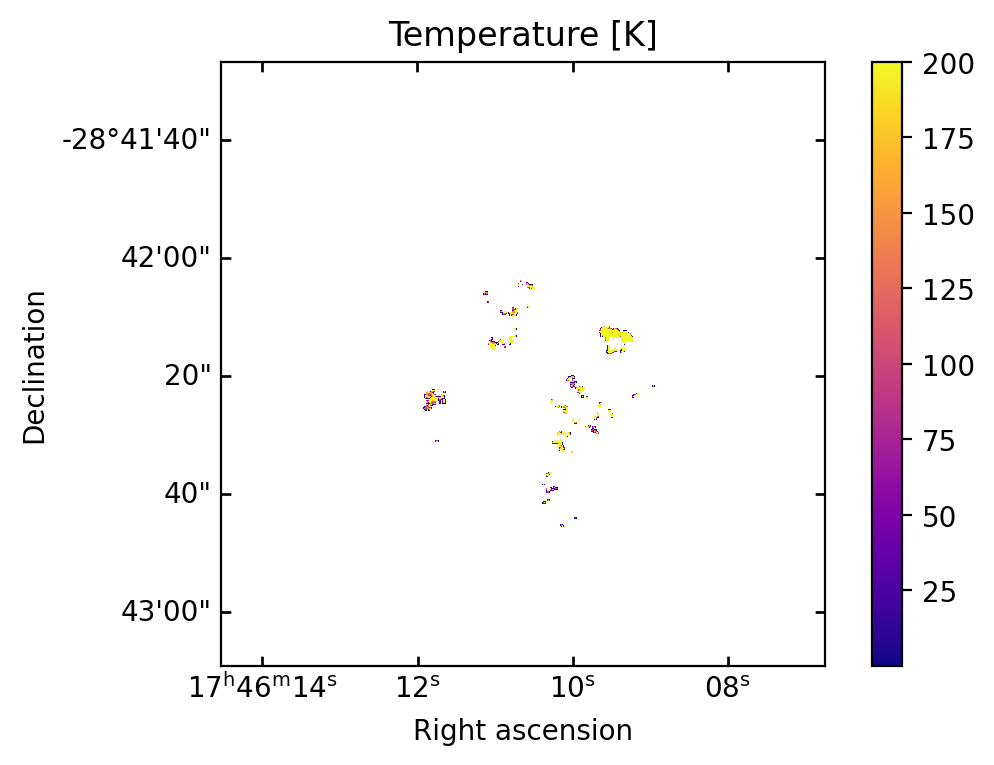

In [24]:
## Temperature map
# Set up colormap
# rock = sns.color_palette("rocket", as_cmap=True)
fig = plt.figure(dpi = 200)
cm = pl.matplotlib.cm.plasma.copy()
cm.set_under('w') # Make sure the "zero" color is white

# Get WCS coordinates from an (arbitrary?) masked cube
masked_cube = SpectralCube.read(f'methyl_cyanide/ch3cn_0_masked.fits', format='fits')
mom0 = masked_cube.moment0()

plt.subplot(111,  projection = mom0.wcs)
plt.imshow(temp_map, vmax=200, vmin=0.001, cmap = cm, origin='lower')
plt.tick_params(direction = 'in')
plt.title('Temperature [K]')
plt.xlabel('Right ascension'); plt.ylabel('Declination')
plt.colorbar()
plt.savefig("../figures/temp_map.pdf", dpi = 300, facecolor='w', edgecolor='w', bbox_inches='tight')

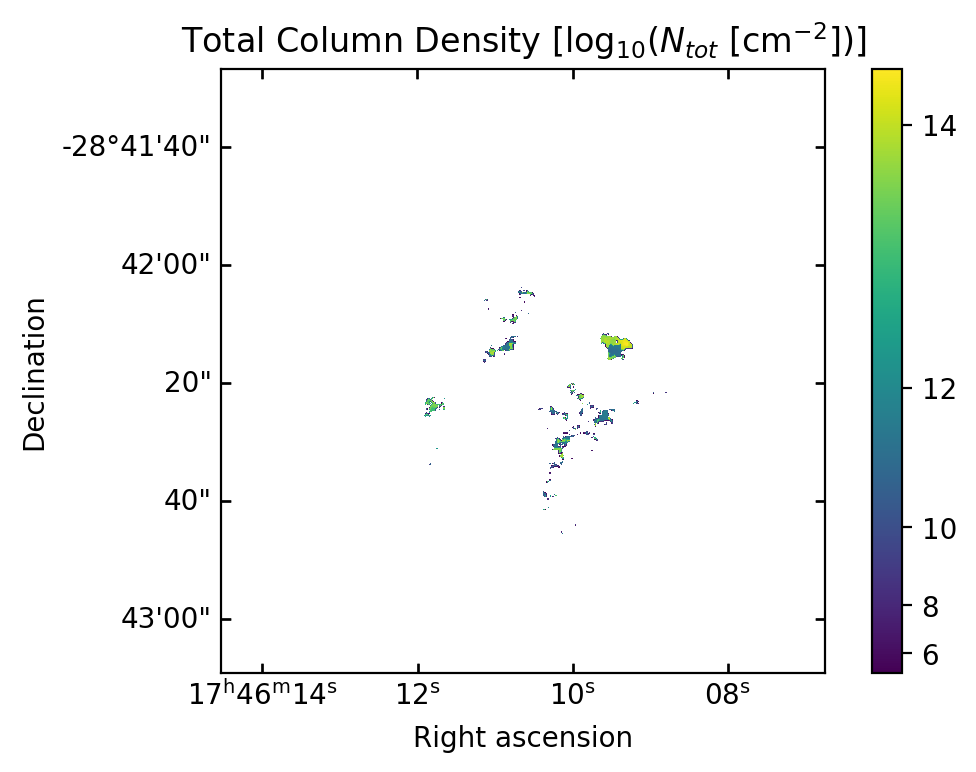

In [25]:
## Column density map
# mako_r = sns.color_palette("mako_r", as_cmap=True)
fig = plt.figure(dpi = 200)
# Set up normalization
from astropy.visualization import imshow_norm, ManualInterval, SqrtStretch, SinhStretch
cm = pl.matplotlib.cm.viridis.copy()
cm.set_under('w') # Make sure the "zero" color is white
# pl.imshow(total_col_density_map, cmap = cm, norm = norm, origin='lower')

plt.subplot(111,  projection = mom0.wcs)
im, norm = imshow_norm(total_col_density_map, origin='lower', cmap = cm, 
                       interval=ManualInterval(vmin = 5.0, vmax = np.max(total_col_density_map)), 
                       stretch=SinhStretch())
plt.tick_params(direction = 'in')
plt.title('Total Column Density [$\log_{{10}}(N_{{tot}}\ [\mathrm{{cm}}^{{-2}}])$]')
plt.xlabel('Right ascension'); plt.ylabel('Declination')
plt.colorbar(mappable=im)
plt.savefig("../figures/coldens_map.pdf", dpi = 300, facecolor='w', edgecolor='w', bbox_inches='tight')

## Step 6. Make diagnostic plots for every pixel

Now, we'll save a diagnostic plot showing the location of the pixel on the temperature map and the column density map as well as the rotational diagram and data/synthetic spectrum for that pixel.

In [26]:
# Get mom1/mom2 estimates
fn = '/blue/adamginsburg/abulatek/brick/first_results/temperature_map/methyl_cyanide/template_cube_masked.fits'
template_cube_masked = SpectralCube.read(fn, format='fits').with_spectral_unit(u.km/u.s)
h2cs_mom1 = template_cube_masked.moment1()
h2cs_linewidth_sigma = template_cube_masked.linewidth_sigma()

In [27]:
# Import statements

# Column density map
from astropy.visualization import imshow_norm, ManualInterval, SqrtStretch, SinhStretch
# Synthetic/real spectra
from astropy import units as u
import numpy as np
import pyspeckit
from pyspeckit.spectrum.models.lte_molecule import get_molecular_parameters
from pyspeckit.spectrum.models import lte_molecule

0it [00:00, ?it/s]

[########################################] | 100% Completed | 10.8s
[########################################] | 100% Completed |  8.1s
1207


<Figure size 900x600 with 0 Axes>

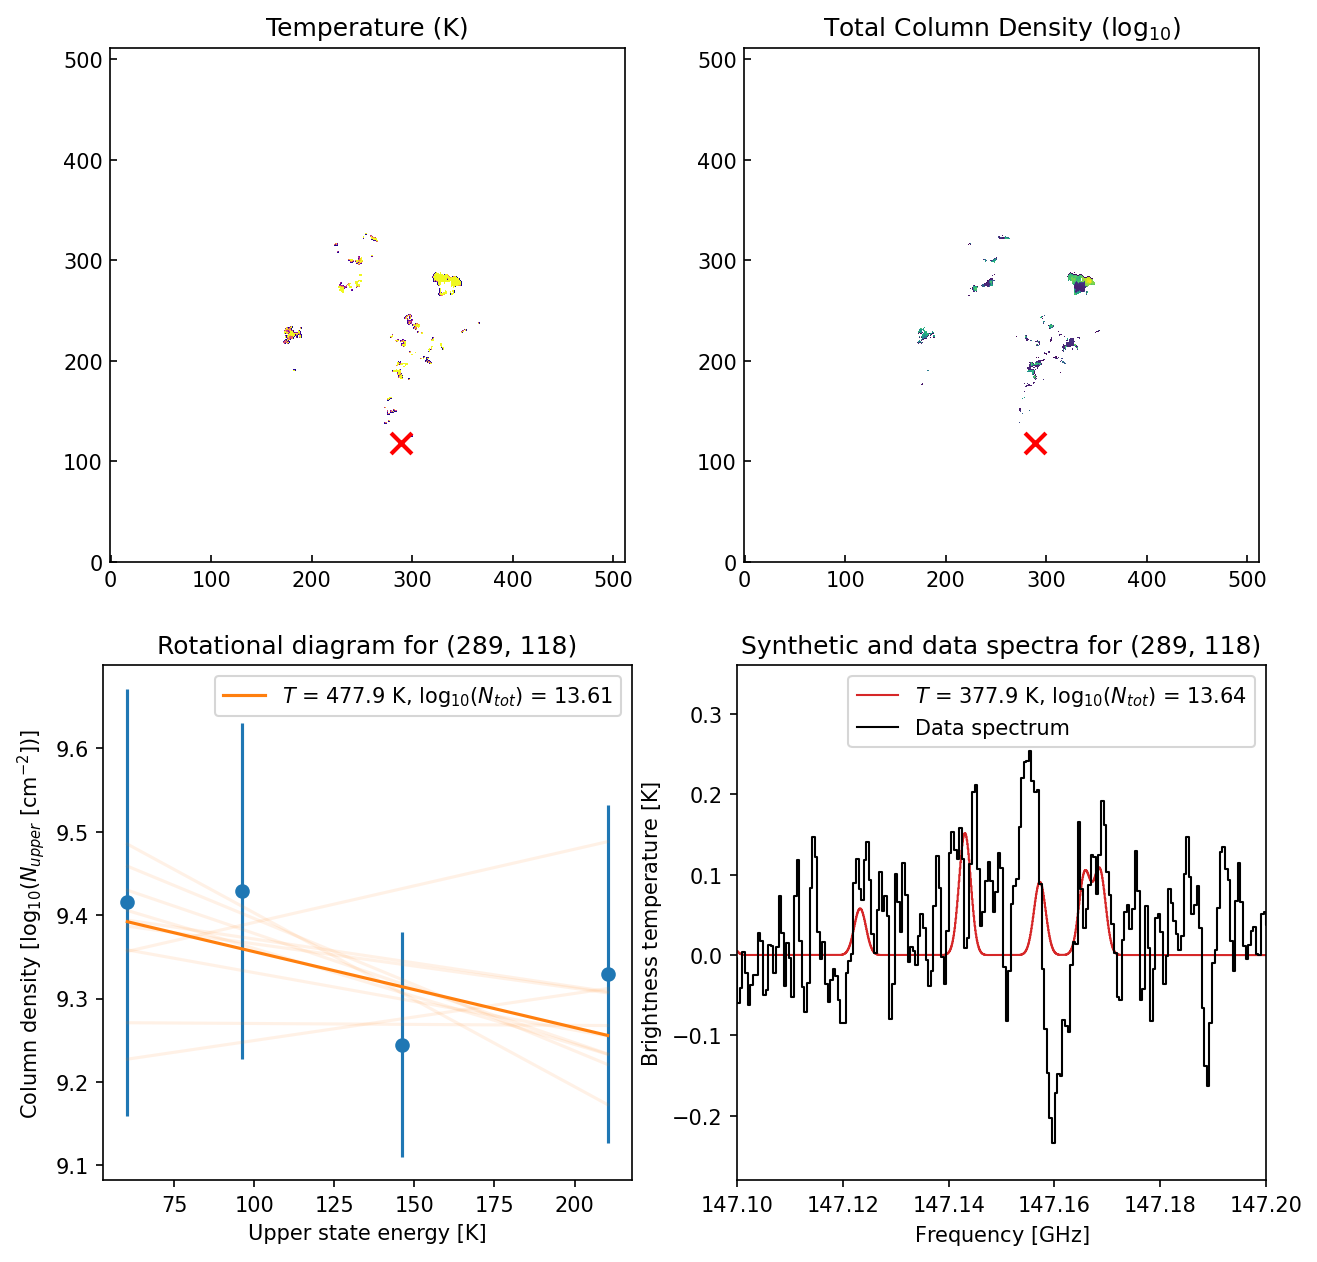

In [28]:
plot_uncertainties = True

flag = False
for index in tqdm(np.ndindex(ln_N_upper_gs.shape[1:])):
    col_density = ln_N_upper_gs[:,index[0],index[1]]
    col_density_errs = ln_N_upper_g_errs[:,index[0],index[1]]
    # Create column density mask, accounting for NaNs and zeros
    col_density_mask = (col_density != 0) & np.isfinite(col_density)
    if not col_density_mask.sum() > 1: # Are there unmasked values? If no, skip index
        continue
    # For all valid pixels...
    
    ##################################################################################################  
    # Add plots: rotational diagram, synth/real spectra, and temp/col maps with X where the pixel is #
    ##################################################################################################
    
    if not flag:
        plt.clf()
        fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 10), num = 0)
        
        ###### Temperature map
        
        cm = pl.matplotlib.cm.plasma.copy()
        cm.set_under('w') # Make sure the "zero" color is white

        ax[0][0].imshow(temp_map, vmax=200, vmin=0.001, cmap = cm, origin='lower')
        ax[0][0].scatter(index[1], index[0], marker = 'x', s = 100, linewidths = 2, color = 'r')
        ax[0][0].tick_params(direction = 'in')
        ax[0][0].set_title('Temperature (K)')
        # ax[0][0].colorbar()
        
        ###### Column density map

        cm = pl.matplotlib.cm.viridis.copy()
        cm.set_under('w') # Make sure the "zero" color is white

        im, norm = imshow_norm(total_col_density_map, origin='lower', cmap = cm, 
                               interval=ManualInterval(vmin = 10, 
                                                       vmax = np.max(total_col_density_map)), 
                               stretch=SinhStretch(), ax = ax[0][1])
        ax[0][1].scatter(index[1], index[0], marker = 'x', s = 100, linewidths = 2, color = 'r')
        ax[0][1].tick_params(direction = 'in')
        ax[0][1].set_title('Total Column Density ($\log_{10}$)')
        # ax[0][1].colorbar(mappable=im)
        
        ###### Rotational diagram
        
        ### Could use the built-in function, but don't know how to throw that plot to a subplot
        
        pixel_x, pixel_y = index[1], index[0]
        col_density_NaN_mask = np.isfinite(ln_N_upper_gs[:,pixel_y,pixel_x]) # ignores NaNs
        col_density_zero_mask = ln_N_upper_gs[:,pixel_y,pixel_x] != 0
        fit_energies = (ch3cn_E_U[::-1])[col_density_zero_mask]
        fit_col_densities = ln_N_upper_gs[:,pixel_y,pixel_x][col_density_zero_mask]
        fit_col_densities_errs = ln_N_upper_g_errs[:,pixel_y,pixel_x][col_density_zero_mask]

        # Do the simple linear fit
        # CONVERT TO K FROM ERGS TO DO THE FIT BECAUSE ERGS HAD SMALL NUMBERS AND THE FIT DIDN'T WORK
        fit_energies_converted = (fit_energies*u.erg/constants.k_B).decompose()
        popt, pcov = curve_fit(linear, fit_energies_converted, fit_col_densities, sigma = fit_col_densities_errs)
        slope, intercept = popt[0], popt[1]

        # Extract the values
        temp = (-1./slope)*u.K
        # temp = (temp*u.erg/constants.k_B).decompose() # DON'T NEED THIS BECAUSE FIT ALREADY DIVIDED BY K_B
        total_col_density = np.log10(np.exp(intercept)*ch3cn_partfunc(temp))
        
        ax[1][0].errorbar(fit_energies_converted, np.log10(np.exp(fit_col_densities)), yerr = np.log10(np.exp(fit_col_densities_errs)), 
                     fmt = 'o', color = 'tab:blue') 
        ax[1][0].plot(fit_energies_converted, np.log10(np.exp(slope*fit_energies_converted.value+intercept)), 
                 label = f"$T$ = {temp:.1f}, $\log_{{10}}(N_{{tot}})$ = {total_col_density:.2f}",
                 color = 'tab:orange') 
        ### PLOT UNCERTAINTIES:
        if plot_uncertainties == True:
            rng = np.random.default_rng()
            rv = rng.multivariate_normal(popt, pcov, 10)
            for param in rv:
                slope, intercept = param[0], param[1]
                temp = (-1./slope)*u.K
                total_col_density = np.log10(np.exp(intercept)*ch3cn_partfunc(temp))
                ax[1][0].plot(fit_energies_converted, np.log10(np.exp(slope*fit_energies_converted.value+intercept)),
                              alpha = 0.1, color = 'tab:orange') 
        ### Why were we exp'ing the y axis???
        # plt.yscale('log')
        ### Why were we log-scaling the y axis???
        ax[1][0].set_title(f"Rotational diagram for ({pixel_x}, {pixel_y})")
        ax[1][0].set_xlabel(f"Upper state energy [K]")
        ax[1][0].set_ylabel(f"Column density [$\log_{{10}}(N_{{upper}}\ [\mathrm{{cm}}^{{-2}}])$]")
        ax[1][0].legend()
        
        ###### Synthetic/real spectra
        
        fmin = 147.1*u.GHz
        fmax = 147.2*u.GHz
        
        sp_axis = np.linspace(fmin, fmax, 1000)
        
        fillingfactor = 1
        offset = 0
        species = 'CH3CN'

        freqs, aij, deg, EU, partfunc = ch3cn_freqs, ch3cn_A_orig, ch3cn_g, ch3cn_E_U, ch3cn_partfunc
        
#         # Get mom1 and mom2 values for a better estimation of the center velocity and velocity dispersion
#         masked_cube_2 = SpectralCube.read(f'methyl_cyanide/ch3cn_2_masked.fits', 
#                                           format='fits').with_spectral_unit(u.km/u.s, velocity_convention = 'radio')
#         mom1 = masked_cube_2.moment1()
#         linewidth_sigma = masked_cube_2.linewidth_sigma() # Yields nan...
        
        v_cen = h2cs_mom1[index[0], index[1]] # 10*u.km/u.s
        v_disp = h2cs_linewidth_sigma[index[0], index[1]] # 1.5*u.km/u.s
        # print(v_cen, v_disp)
        # temp = temperature
        N_tot = total_col_density # - np.log10(2) # This halves N_tot... do not run it unless you want to do that
        
        mod = lte_molecule.generate_model(sp_axis, v_cen, v_disp, temp, N_tot,
                                  freqs, aij, deg, EU, partfunc)
        mod_sp = pyspeckit.Spectrum(xarr = sp_axis.to(u.GHz), data = mod, unit = u.K)
        
        # Get data spectrum
        data_sp = ch3cncube[:, pixel_y, pixel_x]
        data_sp_K = data_sp.value * ch3cncube.jtok_factors()
        data_sp_K_pyspeckit = pyspeckit.Spectrum(xarr = ch3cncube.spectral_axis.to(u.GHz),
                                           data = data_sp_K, unit = u.K)

        mod_sp.plotter(label = f'$T$ = {temp:.1f}, $\log_{{10}}(N_{{tot}})$ = {N_tot:.2f}',
                       color = 'tab:red', linewidth = 1, axis = ax[1][1])
        data_sp_K_pyspeckit.plotter(axis=mod_sp.plotter.axis, clear = False, color = 'k', linewidth = 1,
                            xmin = fmin, xmax = fmax, #ymin = min([min(mod),min(data_sp)]) - 0.3, 
                            # ymax = max([max(mod),max(data_sp)]) + 0.2, 
                            label = 'Data spectrum', 
                            xlabel = f"Frequency [{mod_sp.xarr.unit.to_string('latex_inline')}]", 
                            ylabel = f"Brightness temperature [{mod_sp.unit.to_string('latex_inline')}]")

        plt.title(f"Synthetic and data spectra for ({pixel_x}, {pixel_y})")
        plt.legend()
        if flag == False:
            plt.savefig(f"../diagnostic_plots/x{pixel_x}y{pixel_y}.png", overwrite = True)
        flag = True
        
print(counter)

## Step 7: Walking through the math for an individual pixel

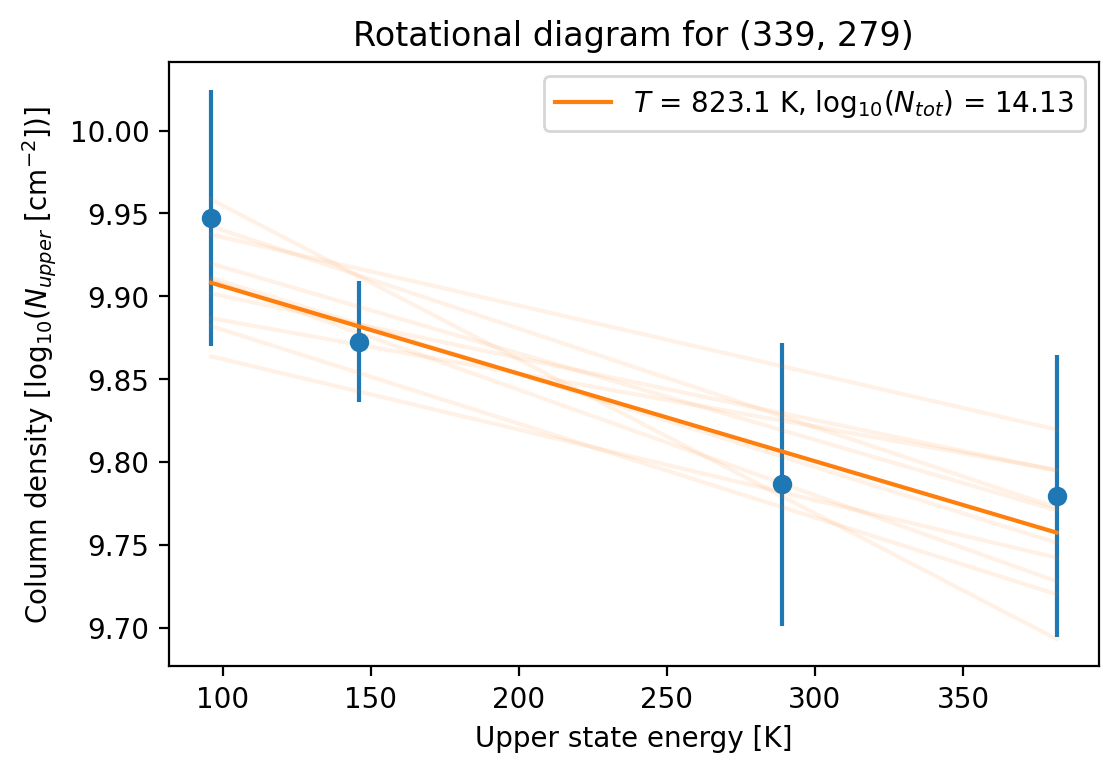

In [29]:
fig = plt.figure(dpi = 200) # I DEFINITELY shouldn't have to run this again
pixel_x, pixel_y = 339, 279 # 246, 274 # 173, 219 # 178, 226 # 227, 270
temperature, total_col_density = rotational_diagram(pixel_x, pixel_y, plot = True, save = True, plot_uncertainties = True)

## Step 8: Synthetic and real spectra comparison

### Step 8.1: Generate a fake spectral axis

We will begin by initializing the spectral axis we want to use for our synthetic spectrum, which will be between some minimum frequency `fmin` and maximum frequency `fmax`.

In [30]:
fmin = 147.1*u.GHz
fmax = 147.2*u.GHz

In [31]:
sp_axis = np.linspace(fmin, fmax, 1000)

### Step 8.2: Generate a synthetic spectrum

With our fake spectral axis, we can generate a synthetic spectrum. We will begin by defining some parameters for the spectrum, i.e. a filling factor and an offset. [should say what these mean]

In [32]:
fillingfactor = 1
offset = 0

Then, we'll define which molecular species we want to include in our synthetic spectrum. This could be expanded to include multiple species, but we'll just use methyl cyanide (CH3CN) for now.

In [33]:
species = 'CH3CN'

Now, we'll get the molecular parameters for this species from Splatalogue. All of the transitions for this molecule between `fmin` and `fmax` will be considered. As an output, the function `get_molecular_parameters` will give us the frequencies, Eistein *A* values, degrees of freedom, and upper-state energies for each of the transitions in the set frequency range, as well as the partition function for that molecule.

In [34]:
freqs, aij, deg, EU, partfunc = get_molecular_parameters(species, fmin = fmin, fmax = fmax)

We will now set several parameters that describe the source, so that they can be user-configurated. These values are the central velocity `v_cen`, the velocity dispersion `v_disp`, the temperature `temp`, and the total column density `N_tot`. [can include multiple velocity components]

In [35]:
v_cen = h2cs_mom1[pixel_y, pixel_x] # 10*u.km/u.s
v_disp = h2cs_linewidth_sigma[pixel_y, pixel_x] # 1.5*u.km/u.s
# temp = 38.32444*u.K
# N_tot = (10**(13.71651))*u.cm**-2
temp = temperature*u.K
N_tot = 10**(total_col_density) / (u.cm**2) # - np.log10(2) # This halves N_tot, so don't run it if you don't want to half N_tot

Now we can generate model data that incorporates all of these transitions under the conditions we just set. The `generate_model` function takes as inputs the spectral axis we created earlier, several properties of the source (the central velocity, the velocity dispersion, the temperature, and the total column density), and the outputs from our query for molecular parameters. [want units—what are they?]

In [36]:
mod = lte_molecule.generate_model(sp_axis, v_cen, v_disp, temp, N_tot,
                                  freqs, aij, deg, EU, partfunc)

We can now build a `pyspeckit.Spectrum` object using this model data and the spectral axis we generated. We can plot this spectrum: it looks like a methyl cyanide ladder!

In [37]:
mod_sp = pyspeckit.Spectrum(xarr=sp_axis.to(u.GHz), data = mod, unit = u.K)

# mod_sp.plotter()

### Step 8.3: Retrieve a spectrum from the data

Now, we will extract a spectrum from a particular pixel of our original `ch3cncube`.

In [38]:
data_sp = ch3cncube[:, pixel_y, pixel_x]

[########################################] | 100% Completed |  8.6s
[########################################] | 100% Completed |  4.8s


In [39]:
data_sp_K = data_sp.value * ch3cncube.jtok_factors()
data_sp_K_pyspeckit = pyspeckit.Spectrum(xarr = ch3cncube.spectral_axis.to(u.GHz),
                                           data = data_sp_K, unit = u.K)

# data_sp_K_pyspeckit.plotter()

### Step 8.4: Plot the synthetic and real spectra on the same plot

Central velocity: -4.40 km / s
Velocity dispersion: 2.90 km / s


<Figure size 900x600 with 0 Axes>

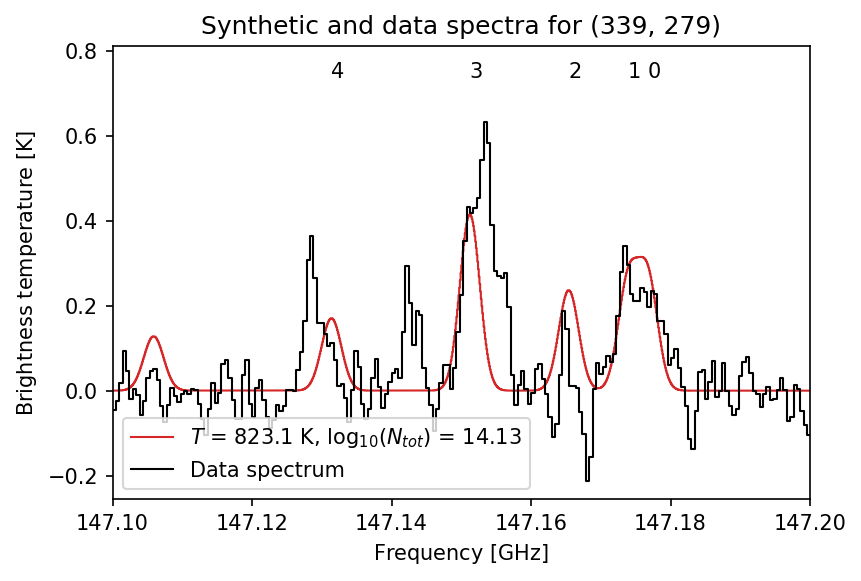

In [40]:
fig = plt.figure(dpi = 150)
mod_sp.plotter(label = f'$T$ = {temp:.1f}, $\log_{{10}}(N_{{tot}})$ = {np.log10(N_tot.value):.2f}',
               color = 'tab:red', linewidth = 1) # $v_{{c}}$ = {v_cen:.2f}, $v_{{disp}}$ = {v_disp:.2f}
data_sp_K_pyspeckit.plotter(axis=mod_sp.plotter.axis, clear = False, color = 'k', linewidth = 1,
                            xmin = fmin, xmax = fmax, #ymin = min([min(mod),min(data_sp)]) - 0.3, ymax = max([max(mod),max(data_sp)]) + 0.2, 
                            label = 'Data spectrum', 
                            xlabel = f"Frequency [{mod_sp.xarr.unit.to_string('latex_inline')}]", 
                            ylabel = f"Brightness temperature [{mod_sp.unit.to_string('latex_inline')}]")
                            
for i in range(len(ch3cn_freqs)): # i is the index of the loop
    if ch3cn_freqs[i].to(u.GHz).value > (plt.xlim()[0] + 0.01) and ch3cn_freqs[i].to(u.GHz).value < (plt.xlim()[1] - 0.01):
        kmax = len(ch3cn_freqs) - 1 # Maximum rotational quantum number for the ladder
        kk = kmax - i # Get rotational quantum number of this iteration
        shifted_freq = (ch3cn_freqs[kmax - kk]-(((v_cen)/(constants.c.to(u.km/u.s)))*ch3cn_freqs[kmax - kk])).to(u.GHz) # Maybe okay?

        plt.text(shifted_freq.value, plt.ylim()[1]-0.075, str(kk))
                            
plt.title(f"Synthetic and data spectra for ({pixel_x}, {pixel_y})")
plt.legend(loc = "lower left")
data_sp_K_pyspeckit.plotter.savefig(f'../figures/ch3cn_spec_datasynth_x{pixel_x}y{pixel_y}.pdf')
                            
print(f"Central velocity: {v_cen:.2f}")
print(f"Velocity dispersion: {v_disp:.2f}")